### Índice
1. Sobre o conjunto de dados
2. Pré-processamento de texto
3. Usar TFIDF para melhorar o vetor de contagem
4. Conclusão

### 1. Sobre o dataset 

CEPs

Há um total de xxx CEPs no conjunto de dados..


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

#######################################
# Execução da GPU na linha de comando #
#       watch -n 1 nvidia-smi         #
#######################################

from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
import matplotlib.pyplot as plt

from joblib import dump
from joblib import load

import time

# Para tratar as palavras dos textos
import unicodedata # Conjunto de caracteres de uniformidade unicode
import re # Regular Expression

# Para possibilitar processamento paralelo
from multiprocessing import  Pool

pd.set_option('display.max_colwidth', None)

### ECT - teste usando estratificação com CEP

In [2]:
arquivo = 'ect_amostra_minas_gerais.csv'
sep = ';'
# ler o dataset
df = pd.read_csv(arquivo, sep=sep)
#df.shape
df.head(1)

,log_nu,ufe_sg,loc_nu,bai_nu_ini,bai_nu_fim,log_no,log_complemento,cep,int_cep,tlo_tx,log_sta_tlo,log_no_abrev,bai_no,bai_no_abrev,mun_nu
0,1008337,MG,4047,57341,0,Ouro Fino,NaN,38042274,38042274,Rua,S,R Ouro Fino,Damha Residencial Uberaba I,D Res Uberaba I,3170107


In [3]:
df.shape

(111880, 15)

In [4]:
# Coluna cep_3d contém os 3 primeiros dígitos do CEP. Junto com ufe_sg cep_3d forma o par
# para a estratificação proporcional dos dados.
df['cep_3d'] = (df['cep']/100000).astype(int)

# label CEP com 5 DÍGITOS
df['label']  = [int(x/1000) for x in df.cep]

# identificador para comparação quando for concatenar
df['id_end'] = [id for id in range(len(df))]

features_end = ['id_end','log_no','bai_no','log_no_abrev','ufe_sg','cep','cep_3d','label']
df[features_end].head(1)

,id_end,log_no,bai_no,log_no_abrev,ufe_sg,cep,cep_3d,label
0,0,Ouro Fino,Damha Residencial Uberaba I,R Ouro Fino,MG,38042274,380,38042


## Preparar amostras
### ECT

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df[features_end], 
                                                    df[['cep']], 
                                                    #test_size=0.2, 
                                                    test_size=0.3, 
                                                    random_state=7,
                                                    stratify=df[['ufe_sg','cep_3d']])
df_end = X_test
del X_train, X_test, y_train, y_test
df_end.shape

(33564, 8)

In [6]:
df_end.head(1)

,id_end,log_no,bai_no,log_no_abrev,ufe_sg,cep,cep_3d,label
111026,111026,Francisco Tarifa,Parque São Sebastião,R Francisco Tarifa,MG,37706154,377,37706


### Stopwords

In [7]:
def load_stoplist():
    stoplist = open("stopwords.txt", "r")
    stoplist = stoplist.read()
    stoplist = set(stoplist.splitlines())
    return stoplist

stopwords = load_stoplist()

## Criar coluna end_txt
### ECT

In [8]:
# =============================================================================
# Aplica o conjunto unicode NFKD Compatibility Decomposition
# https://unicode.org/reports/tr15/ 
# =============================================================================

def norma(old):
    new = ''.join(ch for ch in unicodedata.normalize('NFKD', 
                    str(old)) if not unicodedata.combining(ch))
    return new

#print(norma('são áéíóú'))

In [9]:
# https://github.com/perinm/PI-2020.1/blob/master/Proj%20Final/Data%20Processing.ipynb
def parallelize_dataframe(df, func, n_cores=8):
    """
    Function that parallelizes any function applied to a dataframe
    Input:
    df      - Dataframe
    func    - Function to be aplied to portions of Dataframe
    n_cores - Number of CPU cores to be used on the application of func
    
    """
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [10]:
# https://github.com/perinm/PI-2020.1/blob/master/Proj%20Final/Data%20Processing.ipynb

# Processo que cria a feature end_txt a partir dos campos que compõem um endereço
def preprocessing_df_txt(df):
    #return df[features_txt].apply(lambda x: " ".join(x.astype(str)), axis=1)
    return df[['log_no','bai_no','log_no_abrev']].apply(lambda x: " ".join(x.astype(str)), 
                                                                       axis=1)

In [11]:
# https://github.com/perinm/PI-2020.1/blob/master/Proj%20Final/Data%20Processing.ipynb

#Paralelização do processo que cria a nova feature end_txt
df_end['end_txt'] = parallelize_dataframe(df_end[['log_no','bai_no','log_no_abrev']],
                                          preprocessing_df_txt)
df_end['end_txt'] = [re.sub(r'nan', ' ', x) for x in df_end['end_txt'].str.lower()]
df_end['end_txt'] = [norma(x) for x in df_end['end_txt'].str.lower()]
df_end.shape

(33564, 9)

In [12]:
df_end.head(1)

,id_end,log_no,bai_no,log_no_abrev,ufe_sg,cep,cep_3d,label,end_txt
111026,111026,Francisco Tarifa,Parque São Sebastião,R Francisco Tarifa,MG,37706154,377,37706,francisco tarifa parque sao sebastiao r francisco tarifa


### 4. TFIDF
#### ECT

O TFIDF também pode ser facilmente implementado em Python usando o Sklearn.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# inicializar TFIDF
vec = TfidfVectorizer(max_features=4000, stop_words=stopwords)
# criar TFIDF
tfidf = vec.fit_transform(df_end.end_txt)

tfidf.shape
#tfidf_df.shape

(33564, 4000)

In [14]:
from scipy.sparse import csr_matrix #para transformar DataFrame em Sparse DataFrame otimizado

sp_vec = csr_matrix(tfidf)
tfidf_df = pd.DataFrame.sparse.from_spmatrix(sp_vec)

# amostra
#tfidf_df.iloc[:20, 3000:3050]

# Apagar tfidf porque não mais será utilizado e libera RAM
del tfidf

tfidf_df.shape

(33564, 4000)

`id_bow` comparado com `id_end` para verificar se a concatenação foi adequada

In [15]:
tfidf_df['id_bow'] = [id for id in range(len(tfidf_df))]

In [16]:
tfidf_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,id_bow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [17]:
tfidf_df = pd.concat([df_end[['id_end','ufe_sg','cep_3d','label']], tfidf_df], axis=1, join='inner')

tfidf_df.shape

(9987, 4005)

In [18]:
tfidf_df.head(1)

,id_end,ufe_sg,cep_3d,label,0,1,2,3,4,5,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,id_bow
16803,16803,MG,380,38041,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16803


In [19]:
tfidf_df.label.value_counts()

35162    212
35164    140
35300    116
35160    106
35703    105
        ... 
30440      1
38056      1
38309      1
37704      1
39440      1
Name: label, Length: 691, dtype: int64

Retirando CEPs com quantidade inferior a 3

In [20]:
# ENCODER
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(tfidf_df['ufe_sg'])
tfidf_df['uf'] = label_encoder.transform(tfidf_df['ufe_sg'])

tfidf_df.uf.value_counts()


0    9987
Name: uf, dtype: int64

In [21]:
# Elimina a feature cep_3d criada exclusivamente 
# para amostragem estratificada proporcional por ufe_sg e cep
tfidf_df = tfidf_df.drop(columns=['cep_3d'])
tfidf_df = tfidf_df.drop(columns=['ufe_sg'])
tfidf_df = tfidf_df.drop(columns=['id_bow'])
tfidf_df = tfidf_df.drop(columns=['id_end'])

In [22]:
# DELETA df_end para liberar RAM
del df_end

In [23]:
min_qtd_cep = tfidf_df.label.value_counts()
df_min_qtd_cep = pd.DataFrame(min_qtd_cep)
df_min_qtd_cep

,label
35162,212
35164,140
35300,116
35160,106
35703,105
...,...
30440,1
38056,1
38309,1
37704,1


In [24]:
df_min_qtd_cep.reset_index(inplace=True)

In [25]:
df_min_qtd_cep = df_min_qtd_cep[df_min_qtd_cep['label'] > 1]
df_min_qtd_cep

,index,label
0,35162,212
1,35164,140
2,35300,116
3,35160,106
4,35703,105
...,...,...
590,34019,2
591,35904,2
592,38049,2
593,35704,2


In [26]:
lista_exclui_cep = []
for i in df_min_qtd_cep['index']:
    lista_exclui_cep.append(i)

In [27]:
#teste = tfidf_df[tfidf_df['label']==[x for x in lista_exclui_cep]]
tfidf_df = tfidf_df[tfidf_df['label'].isin(lista_exclui_cep)]
tfidf_df

,label,0,1,2,3,4,5,6,7,8,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,uf
16803,38041,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0
19249,38603,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0
23250,33841,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0
22063,35504,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0
1224,38440,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5240,37417,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0
3060,38421,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0
19482,39800,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0
30106,32425,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0


In [28]:
# Trocando NaN por 0.0
tfidf_df = tfidf_df.fillna(value=0.0)
tfidf_df.shape

(9891, 4002)

In [29]:
y_train = tfidf_df.label
X_train = tfidf_df

X_train.head(1)

,label,0,1,2,3,4,5,6,7,8,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,uf
16803,38041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [30]:
X_train.shape

(9891, 4002)

### NeighbourhoodCleaningRule `resample`

In [31]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule(n_neighbors=1, n_jobs=4)
X_ncr, y_ncr = ncr.fit_resample(X_train,y_train)

/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/sklearn/utils/validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [32]:
X_ncr.shape

(9788, 4002)

In [ ]:
num_class = len(y_train_ncr.unique())
num_class

### NeighbourhoodCleaningRule `model`

### Treina e avalia o modelo usando `train_test_split`

In [38]:
# separa o conjunto de teste
X_train_ncr, X_test_ncr, y_train_ncr, y_test_ncr = train_test_split(X_ncr, 
                                                                    y_ncr, 
                                                                    test_size=0.2, 
                                                                    random_state=21)

# utilizado para gerar os logs dos erros: merror e mlogloss
eval_set = [(X_train_ncr, y_train_ncr), (X_test_ncr, y_test_ncr)]

# métricas de avaliação
eval_metric = ['merror', 'mlogloss']

# Informa a quantidade de classes que serão usadas no treinamento
num_class = len(y_train_ncr.unique())

start = time.time() # inicia o tempo de execução

model_ncr_TTS = XGBClassifier(num_class=num_class, 
                              objective='multi:softmax', 
                              n_jobs=-1, 
                              nthread=-1, 
                              tree_method='gpu_hist', 
                              gpu_id=-1)

model_ncr_TTS = model_ncr_TTS.fit(X_ncr, 
                                  y_ncr, 
                                  eval_metric=eval_metric, 
                                  eval_set=eval_set, 
                                  verbose=True)

elapsed = time.time() - start # informa o tempo de execução

# cria predições no dataset de teste e
## avalia a acurácia da classificação
acuracia = accuracy_score(y_test_ncr, model_ncr_TTS.predict(X_test_ncr))
print("Acurácia model_ncr_TTS: %.2f%%" % (acuracia * 100.0))

#print("Tempo de execução: %f" % (elapsed))
print("GPU Training Time: %s seconds" % (elapsed))

[0]	validation_0-merror:0.79591	validation_0-mlogloss:4.64513	validation_1-merror:0.81461	validation_1-mlogloss:4.75302
[1]	validation_0-merror:0.72861	validation_0-mlogloss:3.96826	validation_1-merror:0.73340	validation_1-mlogloss:3.93330
[2]	validation_0-merror:0.54163	validation_0-mlogloss:3.68904	validation_1-merror:0.54392	validation_1-mlogloss:3.65543
[3]	validation_0-merror:0.44483	validation_0-mlogloss:2.28376	validation_1-merror:0.45659	validation_1-mlogloss:2.23551
[4]	validation_0-merror:0.38838	validation_0-mlogloss:1.80329	validation_1-merror:0.39428	validation_1-mlogloss:1.75049
[5]	validation_0-merror:0.33614	validation_0-mlogloss:1.52148	validation_1-merror:0.32329	validation_1-mlogloss:1.47299
[6]	validation_0-merror:0.30907	validation_0-mlogloss:1.32517	validation_1-merror:0.29520	validation_1-mlogloss:1.28167
[7]	validation_0-merror:0.28084	validation_0-mlogloss:1.18304	validation_1-merror:0.26558	validation_1-mlogloss:1.14312
[8]	validation_0-merror:0.26399	validati

[68]	validation_0-merror:0.20000	validation_0-mlogloss:0.51564	validation_1-merror:0.18386	validation_1-mlogloss:0.50521
[69]	validation_0-merror:0.19975	validation_0-mlogloss:0.51537	validation_1-merror:0.18386	validation_1-mlogloss:0.50481
[70]	validation_0-merror:0.19949	validation_0-mlogloss:0.51508	validation_1-merror:0.18386	validation_1-mlogloss:0.50450
[71]	validation_0-merror:0.19936	validation_0-mlogloss:0.51486	validation_1-merror:0.18386	validation_1-mlogloss:0.50421
[72]	validation_0-merror:0.19936	validation_0-mlogloss:0.51454	validation_1-merror:0.18437	validation_1-mlogloss:0.50391
[73]	validation_0-merror:0.19923	validation_0-mlogloss:0.51425	validation_1-merror:0.18437	validation_1-mlogloss:0.50370
[74]	validation_0-merror:0.19923	validation_0-mlogloss:0.51401	validation_1-merror:0.18437	validation_1-mlogloss:0.50352
[75]	validation_0-merror:0.19923	validation_0-mlogloss:0.51379	validation_1-merror:0.18437	validation_1-mlogloss:0.50319
[76]	validation_0-merror:0.19923

### Métricas de performance recuperadas

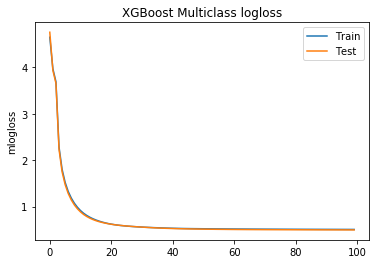

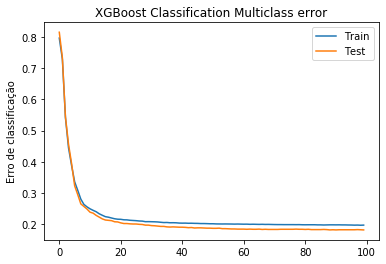

In [39]:
# recupera a performance 
#results = model_ncr_StratifiedKFold.evals_result()
results = model_ncr_TTS.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# gera gráfico mlogloss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost Multiclass logloss')
plt.show()

# gera gráfico classification merror
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Erro de classificação')
plt.title('XGBoost Classification Multiclass error')
plt.show()

Acurácia: 95.46% (0.42%)  
Tempo de execução: 1644.235230

Acurácia: 97.43% (0.33%)  
Tempo de execução: 9567.627274

15/07/2020 - 23h  
Acurácia: 97.40% (0.38%)  
Tempo de execução: 8641.909433

16/07/2020 - 3h  
Acurácia: 97.53% (0.72%)  
Tempo de execução: 15885.853368  

21/07/2020 - 1h  
Acurácia model_ncr: 85.28%  
GPU Training Time: 2577.2702264785767 seconds  

21/07/2020 - 2h25  
Acurácia model_ncr: 85.28%  
GPU Training Time: 2524.836276292801 seconds  

21/07/2020 - 19h45  
Acurácia model_ncr: 81.77%  
GPU Training Time: 8404.782523155212 seconds  

In [40]:
# Grava em disco o modelo treinado e avaliado por train_test_split
#dump(model_ncr, 'cep_model_ncr_TESTE-1-train-test-split.dat')
dump(model_ncr_TTS, 'cep_model_ncr_TESTE-1-GPU.dat')

['cep_model_ncr_TESTE-1-GPU.dat']

In [ ]:
STOP

### Treina e avalia o modelo usando `StratifiedKFold`

In [ ]:
# Informa a quantidade de classes que serão usadas no treinamento
num_class = len(y_ncr.unique())

model_ncr_SKF = XGBClassifier(num_class=num_class, 
                              objective='multi:softmax', 
                              n_jobs=3, 
                              tree_method='gpu_hist', 
                              gpu_id=-1)

start = time.time() # inicia o tempo de execução

# prepara cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=14)
results = cross_val_score(model_ncr_SKF, X_ncr, y_ncr, cv=kfold, n_jobs=3)

elapsed = time.time() - start # informa o tempo de execução

# cria predições no dataset de teste e
## avalia a acurácia da classificação
print("Acurácia: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#print("Tempo de execução: %f" % (elapsed))
print("GPU Training Time: %s seconds" % (elapsed))

In [ ]:
# Grava em disco o modelo treinado e avaliado por StratifiedKFold e cross_val_score
#dump(model_ncr, 'cep_model_ncr_TESTE-1-StratifiedKFold.dat')
dump(model_ncr_SKF, 'cep_model_ncr_TESTE-1-StratifiedKFold.dat')

### TomekLinks `resample`

In [ ]:
from imblearn.under_sampling import TomekLinks
undersample = TomekLinks()
X_tml, y_tml = undersample.fit_resample(X_train,y_train)

In [ ]:
X_tml.shape

### TomekLinks `model`

In [ ]:
model_tml = XGBClassifier(num_class=len(y_train.unique()), 
                          objective='multi:softmax', 
                          n_jobs=4,
                          nthread=16)

start = time.time() # inicia o tempo de execução

# prepara cross validation
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(model_tml, X_tml, y_tml, cv=kfold, n_jobs=4)

elapsed = time.time() - start # informa o tempo de execução

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print("Tempo de execução: %f" % (elapsed))

16/07/2020 - 17h20  
Accuracy: 97.63% (0.57%)  
Tempo de execução: 16230.281697

In [ ]:
params_tml = model_tml
params_tml

In [ ]:
# Grava em disco o modelo treinado e avaliado por train_test_split
dump(model_tml, 'cep_model_tml_TESTE-1-StratifiedKFold.dat')

In [ ]:
# separa o conjunto de treinamento e o de teste
X_train_tml, X_test_tml, y_train_tml, y_test_tml = train_test_split(X_tml, 
                                                                    y_tml, 
                                                                    test_size=0.2, 
                                                                    random_state=84)

# criar o modelo de classificação
model_tml = XGBClassifier(num_class=len(y_train.unique()), 
                          objective='multi:softmax', 
                          n_jobs=4,
                          nthread=16)
#model_ncr = XGBClassifier(params_tml)

# utilizado para gerar os logs dos erros: error e logloss
eval_set = [(X_train_tml, y_train_tml), (X_test_tml, y_test_tml)]

# métricas de avaliação
eval_metric = ['merror', 'mlogloss']

start = time.time() # inicia o tempo de execução

# inicia o treinamento
model_tml = model_tml.fit(X_train_tml, 
                          y_train_tml, 
                          eval_metric=eval_metric, 
                          eval_set=eval_set, 
                          verbose=True)

elapsed = time.time() - start # informa o tempo de execução

## calcula a acurácia
acuracia = accuracy_score(y_test_tml, model_tml.predict(X_test_tml))
print("Acurácia model_tml: %.2f%%" % (acuracia * 100.0))

In [ ]:
# Grava em disco o modelo treinado e avaliado por train_test_split
dump(model_tml, 'cep_model_tml_TESTE-1-train-test-split.dat')

In [ ]:
results = model_tml.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# gera gráfico mlogloss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

# gera gráfico classification merror
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Erro de classificação')
plt.title('XGBoost Classification merror')
plt.show()

### BOW = 4000
- Prevendo os **5 dígitos do CEP**
    - Incluindo como features os CEPs com `2`, `3` e `4` dígitos
        - **Acurácia: 74.33%**
        - Incluindo dígitos separados do CEP: **74.49%**
        - Sem os campos numéricos dos endereços: **76.69%**
        - Somente campos de endereço em comum no SICLI e nos Correios ['log_no','bai_no','log_no_abrev','ufe_sg']
            - **`76.54%`**
    - **Retirados os dígitos do CEP**
        - **Resampling: TomekLinks**
            - **`84.03%`**
            - Somente as variáveis ['log_no','bai_no','log_no_abrev'] + uf (codificado com LabelEncoder)
                - **`88.52%`**   

### Melhor resultado  

- **Resampling: NeighbourhoodCleaningRule**
    - Somente as variáveis ['log_no','bai_no','log_no_abrev'] + uf (codificado com LabelEncoder)
        - **`90.95%`**

### Gera um gráfico de árvore de decisão para cada modelo treinado

In [ ]:
from xgboost import plot_tree
from matplotlib import pyplot

In [ ]:
plot_tree(model_ncr, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(12.5, 4.5)
plt.show()

In [ ]:
plot_tree(model_tml, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(12.5, 4.5)
plt.show()

In [ ]:
print(model_ncr.feature_importances_)

#pyplot.bar(len(model_ncr.feature_importances_), model_ncr.feature_importances_)
plot_importance(model_ncr)
pyplot.show()

In [ ]:
print(model_tml.feature_importances_)

#pyplot.bar(len(model_tml.feature_importances_), model_tml.feature_importances_)
plot_importance(model_tml)
pyplot.show()

### Tunning
- Melhor acurácia: 90.95%
    - model_ncr
- Resampling: NeighbourhoodCleaningRule